<a href="https://colab.research.google.com/github/sekunder/NMA_Project/blob/master/Orientation_Selectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Data retrieval and loading and Matplotlib import
#get the data
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

#load it into a dict
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())
print(dat['sresp'].shape)
N_neurons = dat['sresp'].shape[0]

#import pyplot and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])
(23589, 4598)


dat has fields:
* dat['sresp']: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* dat['run']: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* dat['istim']: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* dat['stat']: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.
* dat['stat'][k]['med']: 1 by 2, the position of each neuron k in tissue, in pixels, at a resolution of ~2um/pix. 
* dat['u_spont']: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* dat['v_spont']: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* dat['u_spont'] @ dat['v_spont']: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.

In [2]:
print("info:",dat['info'])

info: responses of 23589 neurons to 4598 static gratings


In [3]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 

# Number of components to use
n_cmp = 20

Z = zscore(dat['sresp'], axis=1)
p = PCA(n_components = n_cmp)
p.fit_transform(Z.T)
X = p.components_@Z

After the above block runs, the variable `Z` has the z-scored firing rates, and `X` is the top `n_cmp` PCs of the z-scored firing rates.

# Mutual Information

Below, we'll compute the mutual information between each individual neuron's response and the stimulus and the running speed. The MI between the stimulus orientation and the neural response should be a fine measure of "orientation selectivity"

In [4]:
# Using mutual information between stimulus and response as a proxy for "orientation selectivity"
# DANGER! MISTAKES WERE MADE! USE THE FUNCTION IN THE NEXT CELL!
MI_Stimulus = np.zeros(N_neurons)
MI_Running = np.zeros(N_neurons)
HRS = np.zeros(N_neurons)

favorite_neurons = [17, 6, 35, 8, 99]

# hist_bins = 20
R_bins = 10
S_bins = 10
P_S, _ = np.histogram(dat['istim'], density=True, bins=S_bins)
P_speed, speed_bins = np.histogram(dat['run'], density=True, bins=S_bins)
# print(P_S)
for neuron in range(N_neurons):
  P_R, _ = np.histogram(Z[neuron, :], density=True, bins=R_bins)
  
  P_RS, RS_R_bins, RS_S_bins = np.histogram2d(Z[neuron, :], dat['istim'],
                                              bins=[R_bins, S_bins], density=True)
  P_R_P_S = np.outer(P_R, P_S)
  summands_MI = P_RS * np.log2(P_RS / P_R_P_S, out=np.zeros_like(P_RS), where=P_R_P_S!=0)
  # MI_Stimulus[neuron] = np.sum(np.where(~np.isnan(summands_MI)))
  MI_Stimulus[neuron] = np.sum(summands_MI, where=~np.isnan(summands_MI))

  P_R_P_Sp = np.outer(P_R, P_speed)
  P_RSp, RSp_R_bins, RSp_Sp_bins = np.histogram2d(Z[neuron,:], dat['run'],
                                                  bins=[R_bins,S_bins], density=True)
  summands_MIsp = P_RSp * np.log2(P_RSp / P_R_P_Sp, out=np.zeros_like(P_RSp), where=P_R_P_Sp!=0)
  MI_Running[neuron] = np.sum(summands_MIsp, where=~np.isnan(summands_MIsp))

for neuron, mi, misp in zip(favorite_neurons, MI_Stimulus[favorite_neurons], MI_Running[favorite_neurons]):
  print("Neuron",neuron,"has mutual information",mi,"bits with the stimulus, and ",misp," bits with running speed")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


KeyboardInterrupt: ignored

In [5]:
default_xbins = 10
default_ybins = 10

def mutual_information(X, Y, xbins=10, ybins=10):
  """
  Return the mutual information between X and Y. X is a matrix which is N_neurons x N_timepoints, and Y is a vector which is N_timepoints long.

  The way this works: It computes a histogram (normalized to a probability distribution) of Y with ybins number of bins (default 10).
  Likewise, it histograms each row of X (with xbins bins). It then treats these as categorical probability distributions
  and computes the KL divergence beween the product of thesee distributiosn and the joint distribution.

  Example:
  
      MI_stimulus = mutual_information(dat['sresp'], dat['istim'])
  
  This computes the mutual information between neural firing and the stimulus angle.
  """
  MI = np.zeros(X.shape[0])
  P_Y, _ = np.histogram(Y, density=True, bins=ybins)
  P_Y = P_Y / P_Y.sum() # ASSUMING BINS ARE EQUAL WIDTH
  for x_n in range(X.shape[0]):
    P_X, _ = np.histogram(X[x_n,:], density=True, bins=xbins)
    P_X = P_X / P_X.sum() # ASSUMING BINS ARE EQUAL WIDTH
    P_XY, _, _ = np.histogram2d(X[x_n,:], Y, density=True, bins=[xbins,ybins])
    P_XY = P_XY / P_XY.sum() # ASSUMING BINS ARE EQUAL WIDTH
    P_XP_Y = np.outer(P_X, P_Y)

    summands = P_XY * np.log2(P_XY / P_XP_Y, out=np.zeros_like(P_XY), where=P_XP_Y!=0)
    MI[x_n] = np.sum(summands, where=~np.isnan(summands))
  
  return MI


In [6]:
# CORRECTED COMPUTATIONS
MI_Stimulus = mutual_information(Z, dat['istim'])
MI_Running = mutual_information(Z, dat['run'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


In [37]:
np.histogram?

In [17]:
# Testing mutual_information
MI_run_from_func = mutual_information(Z, dat['run'])
MI_stim_from_func = mutual_information(Z, dat['istim'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply


In [40]:
print("Any running MIs computed differently:",(MI_Running - MI_run_from_func)[:10])
print("Any stimulus MIs computed differntly:",(MI_Stimulus - MI_stim_from_func)[:10])

Any running MIs computed differently: [0.00679291 0.0118815  0.05134128 0.04221857 0.00598015 0.01279749
 0.00498044 0.00678801 0.01605086 0.05222966]
Any stimulus MIs computed differntly: [ 0.00608208 -0.00697044 -0.00207791 -0.03746927  0.00425704 -0.07082403
  0.00385456  0.00423607 -0.01330202 -0.00838857]


Text(0.5, 1, 'Bottom, quartiles, and top by MI with stimulus')

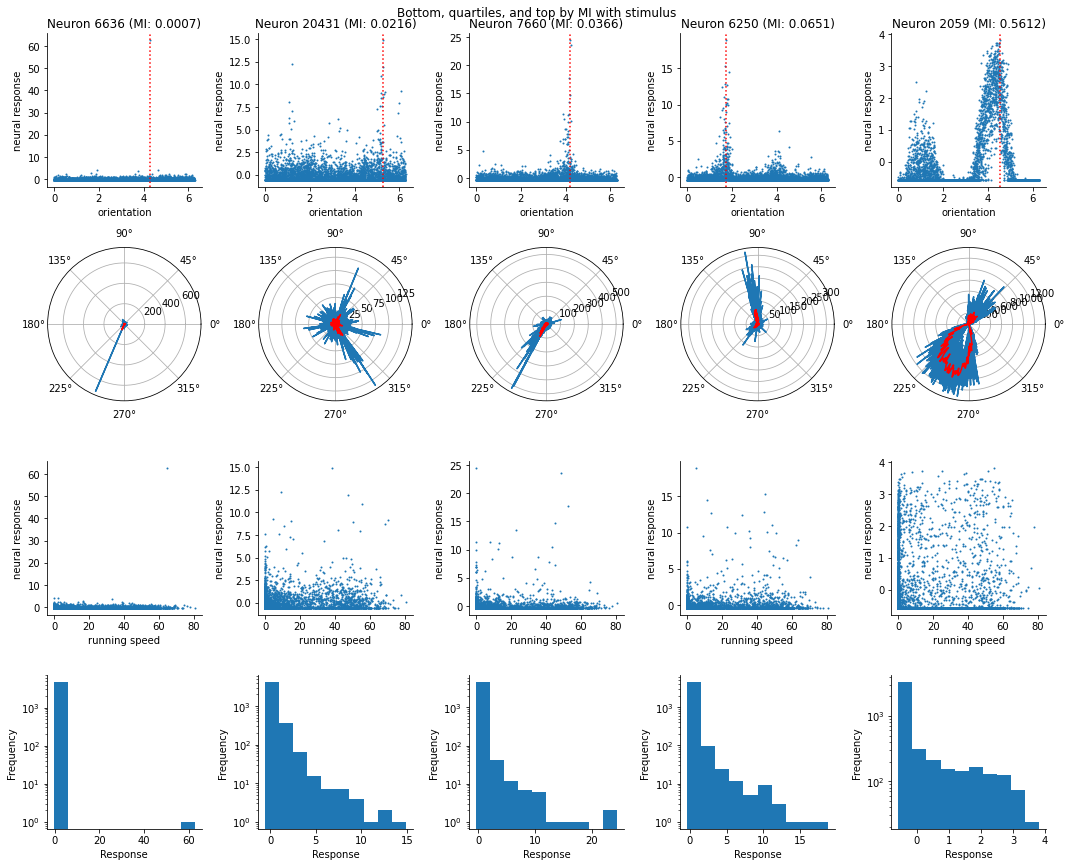

In [7]:
# Starting to play around with individual neuron tuning.
# Ideally, we can find some way to characterize neurons by how "selective" they are
# for orientation, since that's a simple thing to compare between stimuli.
from scipy.ndimage import gaussian_filter1d

fig_rows = 4

R = dat['sresp']
isort = np.argsort(dat['istim'])
R_sorted = R[:,isort]

MI_sort_idx = np.argsort(MI_Stimulus)

O = R @ dat['istim'] / R.sum(axis=1)

# favorite_neurons = [17, 6, 35, 8, 99] 
# favorite_neurons = [8, 99]
# favorite_neurons = np.random.choice(range(N_neurons), size=5)
# favorite_neurons = [838, 19431, 190, 6265, 16355]
favorite_neurons = [MI_sort_idx[0], MI_sort_idx[len(MI_sort_idx)//4], MI_sort_idx[len(MI_sort_idx)//2], MI_sort_idx[-len(MI_sort_idx)//4], MI_sort_idx[-1]]
plt.figure(figsize=(3 * len(favorite_neurons), fig_rows * 3))
for i, n in enumerate(favorite_neurons):
  row = 0
  ax = plt.subplot(fig_rows,len(favorite_neurons),i+1 + row * len(favorite_neurons))
  plt.scatter(dat['istim'], Z[n,:], s=1)
  # plt.axvline(O[n], c='red', linestyle=':')
  plt.axvline(dat['istim'][np.argmax(Z[n, :])], c='red', linestyle=':')
  ax.set(xlabel = 'orientation', ylabel = 'neural response', title='Neuron %d (MI: %.4f)'%(n,MI_Stimulus[n]))

  row += 1
  ax = plt.subplot(fig_rows,len(favorite_neurons), i+1 + len(favorite_neurons), polar=True)
  plt.polar(sorted(dat['istim']), R_sorted[n,:])
  filtered = gaussian_filter1d(R_sorted[n,:], 5)
  plt.polar(sorted(dat['istim']), filtered, c="red")
  # ax.set(xlabel="orientation", ylabel="response")

  # row += 1
  # ax = plt.subplot(fig_rows, len(favorite_neurons), i + 1 + row * len(favorite_neurons))
  # P_RS, RS_R_bins, RS_S_bins = np.histogram2d(Z[neuron, :], dat['istim'],
  #                                             bins=[R_bins, S_bins], density=True)
  # plt.imshow(P_RS)

  row += 1
  ax = plt.subplot(fig_rows, len(favorite_neurons), i+1 + row*len(favorite_neurons))
  plt.scatter(dat['run'], Z[n,:], s=1)
  ax.set(xlabel = 'running speed', ylabel='neural response')

  row += 1
  ax = plt.subplot(fig_rows, len(favorite_neurons), i + 1 + row*len(favorite_neurons))
  plt.hist(Z[n,:], bins=default_xbins)
  ax.set(xlabel="Response", ylabel="Frequency", yscale="log")

plt.suptitle('Bottom, quartiles, and top by MI with stimulus', y=1)

### Looking at a random sampling of neurons

The below cell will plot a figure of `n_rows * n_cols` neurons. Each neuron is plotted as its response vs. stimulus orientation. The title gives the rank (from low to high mutual information), the neuron ID, and the mutual information between that neuron's response and the stimulus orientation (in bits). Neurons are plotted in descending order of mutual information, so we should expect to see each progressively worse-defined "tuning curves" near the end. Note that if a neuron is highly tuned to multiple angles (i.e. it has a multimodal response curve), it might still have high mutual information, so we'll need another way to compute orientation selectivity if we care about that.

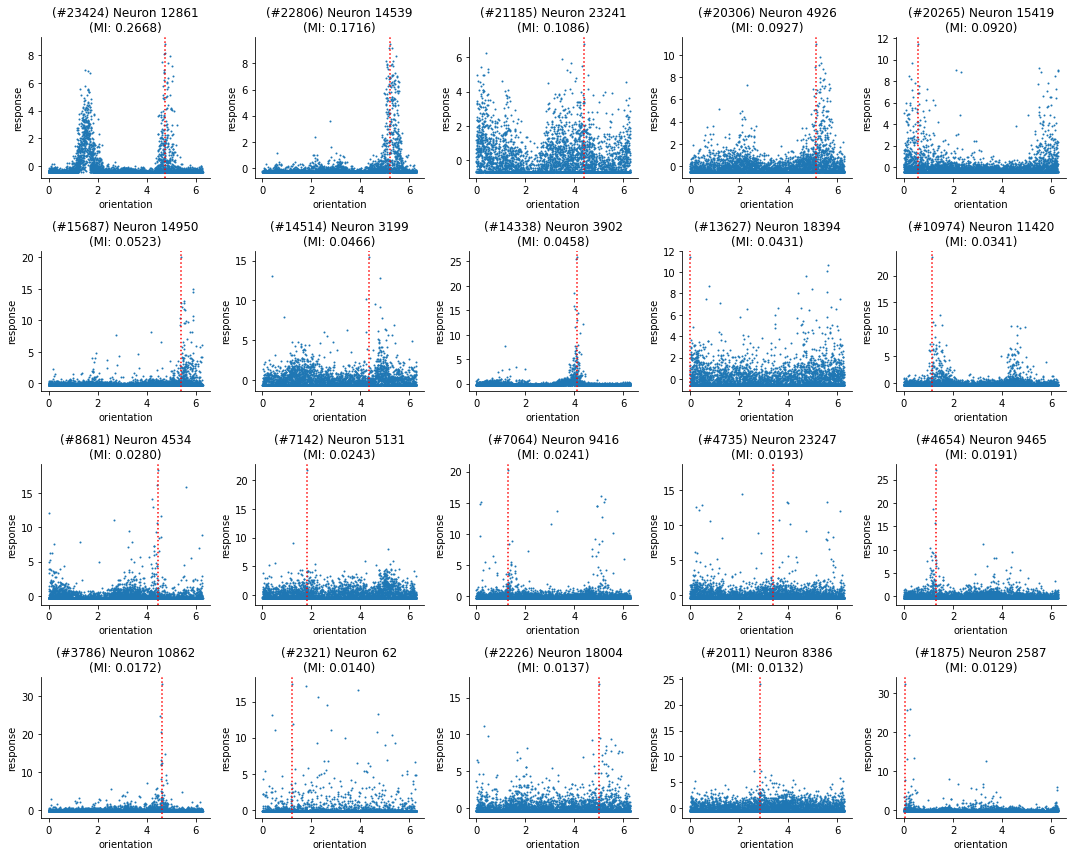

In [8]:
# let's look at a random sampling of neurons

n_rows = 4
n_cols = 5

indices = sorted(np.random.choice(range(N_neurons), size=n_rows * n_cols), reverse=True)
# indices = range(N_neurons-20, N_neurons)
random_neurons = np.argsort(MI_Stimulus)[indices]

plt.figure(figsize=(3 * n_cols, 3 * n_rows))
for i, n in enumerate(random_neurons):
  ax = plt.subplot(n_rows, n_cols, i+1)
  plt.scatter(dat['istim'], Z[n,:], s=1)
  plt.axvline(dat['istim'][np.argmax(Z[n, :])], c='red', linestyle=':')
  ax.set(xlabel = 'orientation', ylabel = 'response', title='(#%d) Neuron %d\n(MI: %.4f)'%(indices[i],n,MI_Stimulus[n]))

[Text(0, 0.5, 'MI with speed'),
 Text(0.5, 0, 'MI with stimulus'),
 Text(0.5, 1.0, 'Speed vs. Stimulus')]

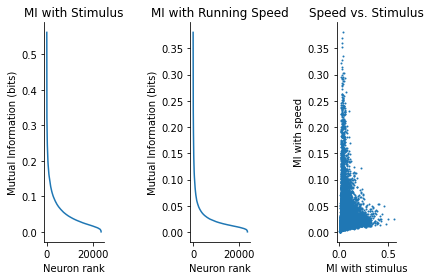

In [10]:
ax = plt.subplot(1,3,1)
plt.plot(range(len(MI_Stimulus)), sorted(MI_Stimulus, reverse=True))
ax.set(xlabel="Neuron rank", ylabel="Mutual Information (bits)", title="MI with Stimulus")

ax = plt.subplot(1,3,2)
plt.plot(range(len(MI_Running)), sorted(MI_Running, reverse=True))
ax.set(xlabel="Neuron rank", ylabel="Mutual Information (bits)", title="MI with Running Speed")

ax = plt.subplot(1,3,3)
plt.scatter(MI_Stimulus, MI_Running, s=1)
ax.set(xlabel='MI with stimulus', ylabel='MI with speed', title="Speed vs. Stimulus")

# Population Information(?)

Now we're going to look at some population-level measures of information

In [20]:
# Starting with mutual information between pairs of neurons
def pairwise_mutual_information(X, xbins=10):
  """
  Compute the pairwise mutual information for all pairs of neurons in X. X is a N_neurons x N_timepoints matrix
  """
  # PX = np.histogram(X, bins=xbins, axis=1)
  N_neurons = X.shape[0]
  PX = np.apply_along_axis(lambda x: np.histogram(x, bins=xbins, density=True)[0], 1, X)
  print("Computed histograms, resulting matrix has shape", PX.shape)
  PX = (PX.T / PX.sum(axis=1)).T
  PMI = np.zeros((N_neurons, N_neurons))
  for i in range(N_neurons):
    #TODO compute the entropy of PX[i,:] and put it in PMI[i,i]
    PMI[i,i] = -np.sum(PX[i,:] * np.log2(PX[i,:], out=np.zeros_like(PX[i,:]), where=PX[i,:]!=0), where=~np.isnan(PX[i,:]))
    if N_neurons <= 10:
      print("Neuron",i,"has entropy",PMI[i,i])
    for j in range(i+1,N_neurons):
      Pij, _, _ = np.histogram2d(X[i,:], X[j,:], bins=[xbins,xbins], density=True)
      Pij = Pij / Pij.sum()
      PiPj = np.outer(PX[i,:], PX[j,:])
      PiPj = PiPj / PiPj.sum()

      summands = Pij * np.log2(Pij / PiPj, out=np.zeros_like(Pij), where=PiPj!=0)
      PMI[i,j] = np.sum(summands, where=~np.isnan(summands))
      PMI[j,i] = PMI[i,j]
  
  return PMI



favorite neurons: [6636, 20431, 7660, 6250, 2059]
[[1.59215625e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.46346802e-05]
 [5.82241288e-01 5.23791266e-02 9.31811955e-03 2.11775444e-03
  9.88285407e-04 9.88285407e-04 5.64734518e-04 1.41183630e-04
  2.82367259e-04 1.41183630e-04]
 [3.97818221e-01 3.69164058e-03 1.05475445e-03 6.15273430e-04
  5.27377226e-04 8.78962043e-05 8.78962043e-05 8.78962043e-05
  0.00000000e+00 1.75792409e-04]
 [5.04327812e-01 1.06580068e-02 2.72119323e-03 1.36059662e-03
  5.66915257e-04 1.02044746e-03 3.40149154e-04 1.13383051e-04
  1.13383051e-04 1.13383051e-04]
 [1.61890311e+00 1.57117132e-01 1.05407696e-01 7.55753295e-02
  7.20948867e-02 8.20390090e-02 6.41395889e-02 6.26479705e-02
  3.62960464e-02 1.19329468e-02]]
Computed histograms, resulting matrix has shape (5, 10)
Neuron 0 has entropy 0.002959836645790542
Neuron 1 has entropy 0.5961172573573733
Neuron 2 has entropy 0.146

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


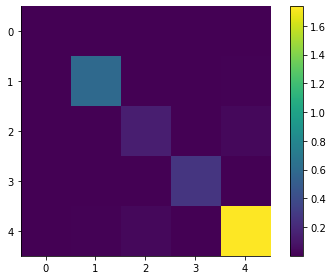

In [21]:
# testing grounds
print("favorite neurons:", favorite_neurons)
X_subset = Z[favorite_neurons,:]
n_bins = 10
# X_sub_hist = np.zeros((X_subset.shape[0], n_bins))
X_sub_hist = np.apply_along_axis(lambda x: np.histogram(x, bins=n_bins, density=True)[0], 1, X_subset)
print(X_sub_hist)

PMI_sub = pairwise_mutual_information(X_subset)

plt.imshow(PMI_sub)
plt.colorbar()
# def my_func(a):
#     """Average first and last element of a 1-D array"""
#     return (a[0] + a[-1]) * 0.5
# b = np.array([[1,2,3], [4,5,6], [7,8,9]])
# print(b)
# print(np.apply_along_axis(my_func, 0, b))
# print(np.apply_along_axis(my_func, 1, b))

In [27]:
selected_neurons = np.arange(1000)
idx = np.argsort(MI_Stimulus)
Z_sorted = Z[idx[selected_neurons], :]
PMI = pairwise_mutual_information(Z_sorted)

Computed histograms, resulting matrix has shape (1000, 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


Text(0, 0.5, 'Neuron index')

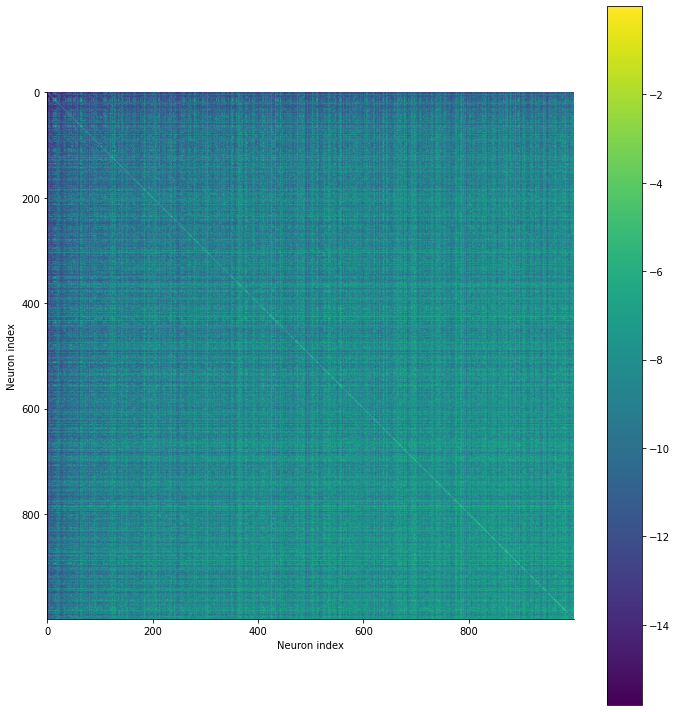

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(PMI))
plt.colorbar()
plt.xlabel("Neuron index")
plt.ylabel("Neuron index")

# Multiscale Relevance

Below we'll attempt to compute something like the multiscale relevance of neural activity during spontaneous activity. Note that this spontaneous activity, as provided here, is a reconstruction from the top 128 principal components.

It may be interesting to compare the overall "feel" of the MSR in this data with the MSR in the longer spontaneous recordings.

In [ ]:
Spont = dat['u_spont'] @ dat['v_spont']
Spont.shape

(23589, 910)

## Computing $H[s]$

The first part of computing MSR is computing the "spike timing information" (or whatever you want to call it)

$$ H[s; \Delta t] = - \sum_{s=1}^T \frac{k_s}{M} \log_M\frac{k_s}{M}. $$

Here $k_s$ is the number of spikes in time bin $s$, $T$ is the total number of time bins, $M$ is the total number of spikes, and each bin has width $\Delta t$.

We're dealing with binned calcium fluorescence data, so it's not totally clear how we will count spikes. I'll try this approach first: Let $\Delta t = 1,2,\dots$ be the number of bins we combine, and $k_s$ will just be the sum of entries in $Z$ in those bins.

In [ ]:
def Hs(z, dt=1):
  """
  Compute the spike timing information for fluorescence trace z, using dt bins at a time.
  """
  M = sum(z)
  z_binned = np.array([np.sum(z[(i*dt):((i+1)*dt)]) for i in range(np.ceil(len(z) / dt).astype(int))])
  ks_over_M = z_binned[z_binned.nonzero()] / M
  return -np.sum(ks_over_M * np.log(ks_over_M) / np.log(M))

## Computing $H[K]$

Now we'll compute the "state information",

$$ H[K; \Delta t] = - \sum_{k = 1}^M \frac{k m_k}{M} \log_M \frac{km_k}{M}. $$

Here, $m_k$ is the number of time bins with activity $k$. Here we have a problem, since we have activity in the form of a continuous variable and not discrete spike counts. So, for now I'll add an auxiliary parameter $n_{bins}$, which we will use to bin the response. Then $k$ will be the midpoint of the corresponding bin.

In [ ]:
def HK(z, dt=1, nb=20):
  """
  Compute the state information for fluorescence trace z, using dt bins at a time, binning the activity into nb bins.
  """
  M = sum(z)
  z_binned = np.array([np.sum(z[(i*dt):((i+1)*dt)]) for i in range(np.ceil(len(z) / dt).astype(int))])
  mk, bin_edges = np.histogram(z_binned, bins=nb)
  ks = bin_edges[0:-1] + np.diff(bin_edges)/2
  kmk = mk * ks
  kmk_over_M = kmk[kmk.nonzero()] / M
  return - np.sum(kmk_over_M * np.log(kmk_over_M) / np.log(M))

[Text(0, 0.5, 'H[K]'),
 Text(0.5, 0, 'H[s]'),
 Text(0.5, 1.0, 'State vs. Spiking')]

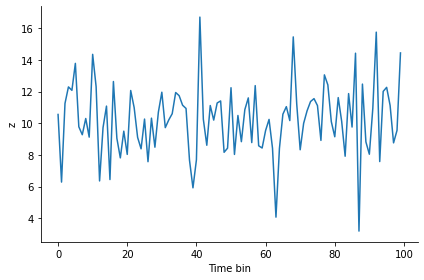

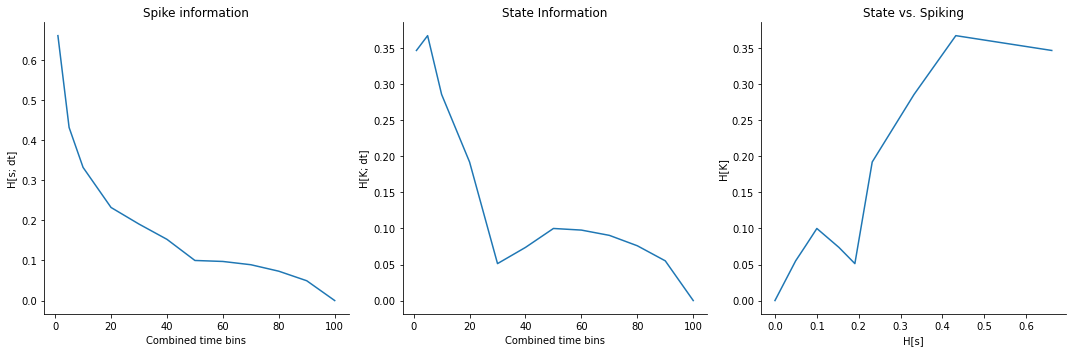

In [ ]:
# Let's test out Hs and HK

np.random.seed(17)
z = 10 + 2 * np.random.randn(100)
plt.plot(range(len(z)), z)
plt.xlabel("Time bin")
plt.ylabel("z")
dts = [1, 5,10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

H_s = np.array([Hs(z, dt) for dt in dts])

H_K = np.array([HK(z, dt) for dt in dts])

# print(H_s)

plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
plt.plot(dts, H_s) # should be monotone decreasing to 0
ax.set(xlabel="Combined time bins", ylabel="H[s; dt]", title="Spike information")
# unfortunately, won't hit Hs = 1 because we can't bin at the resolution of single spikes

ax = plt.subplot(1,3,2)
plt.plot(dts, H_K) # should by a single hump, beginning and ending near 0
ax.set(xlabel="Combined time bins", ylabel="H[K; dt]", title="State Information")

ax = plt.subplot(1,3,3)
plt.plot(H_s, H_K) # should also be a single hump
ax.set(xlabel="H[s]", ylabel="H[K]", title="State vs. Spiking")

# Attempting dPCA 

Below, we try to use dPCA

In [ ]:
#@title Load dPCA code
!git clone https://github.com/machenslab/dPCA.git
import os, sys
sys.path.append("/content/dPCA/python")
from dPCA import dPCA

Cloning into 'dPCA'...
remote: Enumerating objects: 264, done.
remote: Total 264 (delta 0), reused 0 (delta 0), pack-reused 264
Receiving objects: 100% (264/264), 1.28 MiB | 8.05 MiB/s, done.
Resolving deltas: 100% (127/127), done.


/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/dPCA/python/dPCA/nan_shuffle.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [ ]:
# Trying to figure out how to organize the data so dPCA can be used
idx = np.argsort(dat['istim'])
sorted_angles = np.sort(dat['istim'])
indices = np.arange(len(sorted_angles))
# R_binned = np.zeros()
for i in range(20):
  idx_range = indices[((i * np.pi / 10) < sorted_angles) & (sorted_angles < (i+1) * (np.pi / 10))]
  print(min(idx_range), max(idx_range), '# samples: ', max(idx_range) - min(idx_range))
  

0 247 # samples:  247
248 455 # samples:  207
456 682 # samples:  226
683 919 # samples:  236
920 1157 # samples:  237
1158 1410 # samples:  252
1411 1638 # samples:  227
1639 1859 # samples:  220
1860 2075 # samples:  215
2076 2295 # samples:  219
2296 2518 # samples:  222
2519 2770 # samples:  251
2771 3001 # samples:  230
3002 3237 # samples:  235
3238 3455 # samples:  217
3456 3688 # samples:  232
3689 3912 # samples:  223
3913 4155 # samples:  242
4156 4381 # samples:  225
4382 4597 # samples:  215
